# Chapter 13: Parallelizing Neural Network Training with TensorFlow  (Part 2/2)


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

## Building a neural network model in TensorFlow

### The TensorFlow Keras API (tf.keras)

### Building a linear regression model

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

In [ ]:
for x,y in ds_train_orig:
    print(y.numpy())

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b


model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

In [ ]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

In [ ]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [ ]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

In [ ]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('ch13-linreg-1.pdf')

plt.show()

### Model training via the .compile() and .fit() methods

In [ ]:
tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

In [ ]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)


In [ ]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [2]:
import tensorflow_datasets as tfds

iris, iris_info = tfds.load('iris', with_info=True)

print(iris_info)

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]
Dl Completed...: 100%|██████████| 1/1 [00:00<00:00,  1.09 url/s]
                                                                

Dataset iris downloaded and prepared to C:\Users\nnnpo\tensorflow_datasets\iris\2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\nnnpo\\tensorflow_datasets\\iris\\2.0.0',
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),

In [5]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [6]:
ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)
print(type(ds_orig))

<class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>


In [7]:
## checking the number of examples:

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


In [8]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [9]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [10]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [11]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

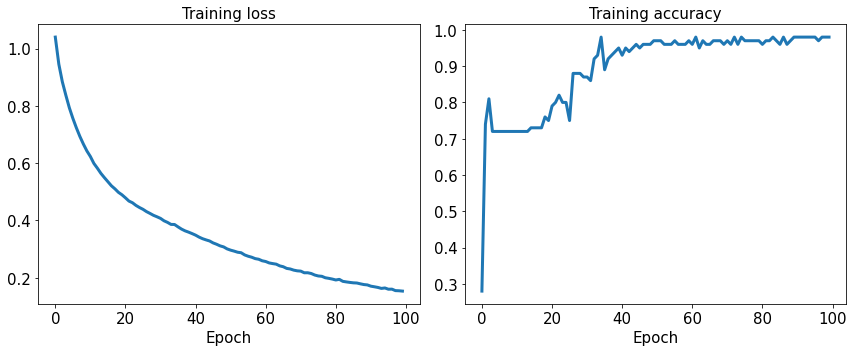

In [12]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

### Evaluating the trained model on the test dataset

In [13]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1557   Test Acc.: 0.9800


### Saving and reloading the trained model

In [ ]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [ ]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

In [ ]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

In [ ]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

In [ ]:
iris_model_new.to_json()

## Choosing activation functions for multilayer neural networks


### Logistic function recap

In [ ]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 

In [ ]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

In [ ]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class) 

### Estimating class probabilities in multiclass classification via the softmax function

In [ ]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

In [ ]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

### Broadening the output spectrum using a hyperbolic tangent

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
np.tanh(z)

In [ ]:
import tensorflow as tf

tf.keras.activations.tanh(z)

In [ ]:
from scipy.special import expit

expit(z)

In [ ]:
tf.keras.activations.sigmoid(z)

### Rectified linear unit activation

In [ ]:
import tensorflow as tf

tf.keras.activations.relu(z)

## Summary

# Appendix

## Splitting a dataset: danger of mixing train/test examples

In [ ]:
## the correct way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=False)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

In [ ]:
## The wrong way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=True)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

### Splitting a dataset using `tfds.Split`

In [ ]:

##--------------------------- Attention ------------------------##
##                                                              ##
##     Note: currently, tfds.Split has a bug  in TF 2.0.0       ##
##                                                              ##
##  I.e., splitting [2, 1] is expected to result in             ##
##      100 train and 50 test examples                          ##
##                                                              ##
##  but instead, it results in 116 train and 34 test examples   ##
##                                                              ##
##--------------------------------------------------------------##

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

##  method 1: specifying percentage:
#first_67_percent = tfds.Split.TRAIN.subsplit(tfds.percent[:67])
#last_33_percent = tfds.Split.TRAIN.subsplit(tfds.percent[-33:])

#ds_train_orig = tfds.load('iris', split=first_67_percent)
#ds_test = tfds.load('iris', split=last_33_percent)


##  method 2: specifying the weights
split_train, split_test = tfds.Split.TRAIN.subsplit([2, 1])

ds_train_orig = tfds.load('iris', split=split_train)
ds_test = tfds.load('iris', split=split_test)

print(next(iter(ds_train_orig)))
print()
print(next(iter(ds_test)))


ds_train_orig = ds_train_orig.shuffle(100, reshuffle_each_iteration=True)
ds_test  = ds_test.shuffle(50, reshuffle_each_iteration=False)

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

print(next(iter(ds_train_orig)))


for j in range(5):
    labels_train = []
    for i,item in enumerate(ds_train_orig):
        labels_train.append(item[1].numpy())

    labels_test = []
    for i,item in enumerate(ds_test):
        labels_test.append(item[1].numpy())
    print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

    labels_test = np.array(labels_test)

    print(np.sum(labels_test == 0), np.sum(labels_test == 1), np.sum(labels_test == 2))

<br>
<br>
<br>